In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import cv2
from google.colab.patches import cv2_imshow


In [ ]:
!pip install mediapipe

In [ ]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 20.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.6 which is incompatible.


In [3]:
!wget -q https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task

In [4]:
# Download the dataset.
folder_id = "1jOPbgYYaZnHZNxNywaE18iLfJIJZOgFW"
output = "data"

# Download the folder using gdown
!gdown --folder --id $folder_id -O $output

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Retrieving folder contents
Processing file 1cHrLgf_7xScBHxnvnlCkvAy_iYGscN3w hand_landmarks_data.csv
Processing file 1pgHNoeU1U-OHSkRIJUOfUe0QOJguQb4Q output.mp4
Processing file 1e1DVZXga6ypR_MQg64wOEJPOlhm4YjqORj8Eh8kMfz0 Project Description
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1cHrLgf_7xScBHxnvnlCkvAy_iYGscN3w
To: /content/data/hand_landmarks_data.csv
100% 31.8M/31.8M [00:01<00:00, 25.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1pgHNoeU1U-OHSkRIJUOfUe0QOJguQb4Q
To: /content/data/output.mp4
100% 14.8M/14.8M [00:00<00:00, 28.3MB/s]
Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the pe

In [5]:
# Take a look at the data
df = pd.read_csv('/content/data/hand_landmarks_data.csv')
df.head()

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,x19,y19,z19,x20,y20,z20,x21,y21,z21,label
0,262.669968,257.304901,-3.649205e-07,257.417542,247.109055,0.004224,246.882957,241.716827,0.005798,236.384537,...,223.345093,255.490692,-0.020450,215.043365,258.114746,-0.024577,208.006393,259.608673,-0.026722,call
1,83.351778,346.059113,-2.345265e-07,81.925037,328.562347,-0.011102,90.080132,311.535248,-0.021096,95.641823,...,132.451618,341.794434,-0.038175,142.773582,342.829254,-0.037336,152.431698,343.015991,-0.036136,call
2,187.756977,260.235492,-2.417307e-07,195.460579,241.506035,-0.000184,207.259529,223.674339,-0.009687,215.413628,...,250.301010,268.602938,-0.044068,262.425133,271.276638,-0.040469,272.989952,272.272231,-0.038301,call
3,114.976696,331.594238,-1.233261e-07,114.503494,320.549957,-0.002824,116.636627,310.080994,-0.008911,117.685066,...,145.195450,329.357544,-0.027622,151.053200,329.712341,-0.027863,155.990364,329.548828,-0.027723,call
4,188.795288,141.727867,-1.622995e-07,188.520905,127.947464,-0.002884,191.982880,111.010563,-0.008115,192.552521,...,226.696396,132.263248,-0.025113,234.831741,130.684147,-0.024087,241.587769,128.477188,-0.023486,call


In [6]:
# Check the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25675 entries, 0 to 25674
Data columns (total 64 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      25675 non-null  float64
 1   y1      25675 non-null  float64
 2   z1      25675 non-null  float64
 3   x2      25675 non-null  float64
 4   y2      25675 non-null  float64
 5   z2      25675 non-null  float64
 6   x3      25675 non-null  float64
 7   y3      25675 non-null  float64
 8   z3      25675 non-null  float64
 9   x4      25675 non-null  float64
 10  y4      25675 non-null  float64
 11  z4      25675 non-null  float64
 12  x5      25675 non-null  float64
 13  y5      25675 non-null  float64
 14  z5      25675 non-null  float64
 15  x6      25675 non-null  float64
 16  y6      25675 non-null  float64
 17  z6      25675 non-null  float64
 18  x7      25675 non-null  float64
 19  y7      25675 non-null  float64
 20  z7      25675 non-null  float64
 21  x8      25675 non-null  float64
 22

In [7]:
# Look for NaNs
df.isna().sum().sum()

np.int64(0)

In [8]:
# Check the dataframe for any non-numeric values
for column in df.columns:
  if not pd.api.types.is_numeric_dtype(df[column]):
    print(f"Column '{column}' contains non-numeric values.")

Column 'label' contains non-numeric values.


In [9]:
# Observe the labels
df["label"].value_counts()

,count
label,
three2,1653
palm,1649
four,1634
ok,1592
stop_inverted,1567
call,1506
peace_inverted,1497
stop,1482
rock,1458


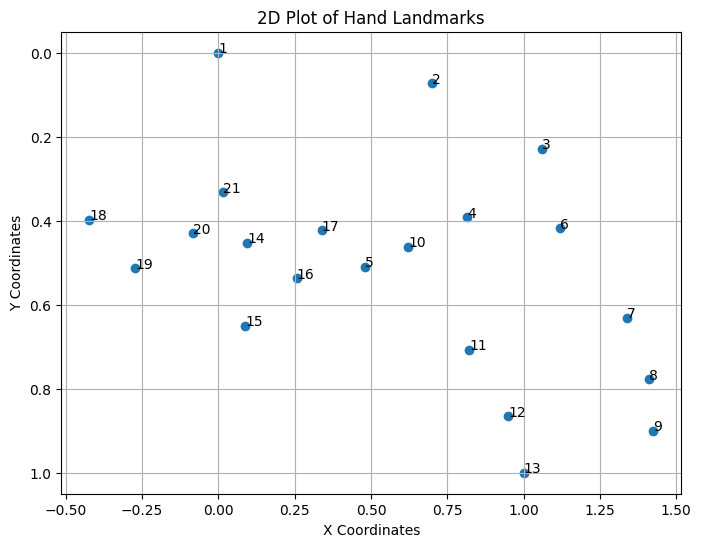

In [71]:
# plot an image
sample_df = df.sample(7)

# Extract the coordinates for the sample
x_coords = [sample_df[f'x{i}'].values[0] for i in range(1, 22)]
y_coords = [sample_df[f'y{i}'].values[0] for i in range(1, 22)]
# label = sample_df['label'].values[0]

# Create the plot
plt.figure(figsize=(8, 6))
plt.scatter(x_coords, y_coords)

# Add labels and title
for i, (x, y) in enumerate(zip(x_coords, y_coords)):
  plt.annotate(i + 1, (x, y))

plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')
plt.title(f'2D Plot of Hand Landmarks')
plt.grid(True)

# Invert the y-axis
plt.gca().invert_yaxis()

plt.show()


In [11]:
# Display all columns
pd.set_option('display.max_columns', None)

In [12]:
# Observe the distribution of the data
df.describe()

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,y4,z4,x5,y5,z5,x6,y6,z6,x7,y7,z7,x8,y8,z8,x9,y9,z9,x10,y10,z10,x11,y11,z11,x12,y12,z12,x13,y13,z13,x14,y14,z14,x15,y15,z15,x16,y16,z16,x17,y17,z17,x18,y18,z18,x19,y19,z19,x20,y20,z20,x21,y21,z21
count,25675.000000,25675.000000,2.567500e+04,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000
mean,201.958632,260.158527,1.272461e-07,202.517395,252.115322,-0.009465,202.862981,240.645966,-0.015946,203.025267,231.684450,-0.022772,202.966979,226.269003,-0.029150,202.748369,226.255575,-0.011015,203.047902,213.496471,-0.023341,203.025185,206.581444,-0.031587,202.939537,200.498964,-0.036539,202.332967,226.209064,-0.014324,202.520204,213.070576,-0.026699,202.481818,207.660820,-0.033022,202.434025,202.627671,-0.035749,202.027209,229.245052,-0.018841,202.177061,220.038483,-0.032494,202.211731,220.993717,-0.034022,202.232146,221.068921,-0.032048,201.721609,234.378377,-0.024129,201.792374,227.455597,-0.033751,201.811275,227.802576,-0.032208,201.874802,227.807287,-0.028828
std,90.500333,76.533210,2.737932e-07,84.770933,75.384691,0.010376,80.412089,74.721921,0.013973,79.647588,74.923091,0.017201,80.777001,75.433577,0.020555,81.486053,74.174662,0.011410,78.660264,75.193943,0.016304,77.695517,76.414925,0.019864,77.304606,77.817092,0.022231,85.044490,74.757306,0.012105,84.003401,76.411499,0.018234,83.878024,78.804974,0.020896,83.966876,81.326327,0.022003,89.052866,75.530619,0.013458,89.047221,76.805159,0.020278,88.354398,78.553745,0.021083,88.068275,80.635173,0.021304,93.354905,76.412992,0.015658,94.046497,77.231210,0.020453,93.664595,78.441253,0.020877,93.547017,79.963438,0.021136
min,-36.050926,45.722923,-2.029986e-06,7.184681,51.256840,-0.096630,25.114323,45.489950,-0.155846,23.446341,38.851536,-0.223258,13.243541,19.964561,-0.282578,23.007730,41.025543,-0.176002,7.846868,12.058107,-0.242614,24.513308,27.764654,-0.279875,20.750772,11.701990,-0.302675,26.686532,38.545681,-0.178811,11.681391,17.029541,-0.230100,21.732645,24.313637,-0.269950,12.205227,9.170517,-0.282490,18.742111,35.284714,-0.170851,8.862213,15.022144,-0.271215,11.509277,21.557108,-0.278481,13.415025,11.011627,-0.253293,4.522356,30.686922,-0.201897,0.198635,20.146784,-0.286821,3.278137,32.158108,-0.286470,-4.537216,23.226204,-0.262047
25%,124.110329,205.815950,-5.243216e-08,130.535929,197.999625,-0.015199,136.711035,187.018583,-0.023020,138.905817,177.897360,-0.030877,139.830317,172.346912,-0.038417,135.349077,173.119514,-0.016189,139.631676,160.014862,-0.030574,141.088646,151.965836,-0.040268,141.518023,144.926865,-0.046269,131.467953,172.890533,-0.019602,133.723944,158.572586,-0.034752,134.446735,151.556170,-0.042468,134.941040,145.513020,-0.045741,128.587727,175.506911,-0.024630,130.301594,165.454178,-0.041456,130.504211,165.620058,-0.043919,130.167824,164.591892,-0.042403,126.202721,180.296774,-0.030728,126.828913,172.720392,-0.042726,126.887403,172.345467,-0.041957,126.356627,172.083794,-0.039220
50%,199.667847,255.181793,1.497277e-07,199.979530,247.113892,-0.008737,200.092758,235.776978,-0.014231,200.482040,226.828033,-0.020179,200.140117,221.246796,-0.025666,199.457932,221.213181,-0.009502,199.514259,208.351471,-0.020488,199.270821,201.778839,-0.027943,199.146263,195.717651,-0.032342,199.286728,220.864047,-0.012345,199.699150,20

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25675 entries, 0 to 25674
Data columns (total 64 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      25675 non-null  float64
 1   y1      25675 non-null  float64
 2   z1      25675 non-null  float64
 3   x2      25675 non-null  float64
 4   y2      25675 non-null  float64
 5   z2      25675 non-null  float64
 6   x3      25675 non-null  float64
 7   y3      25675 non-null  float64
 8   z3      25675 non-null  float64
 9   x4      25675 non-null  float64
 10  y4      25675 non-null  float64
 11  z4      25675 non-null  float64
 12  x5      25675 non-null  float64
 13  y5      25675 non-null  float64
 14  z5      25675 non-null  float64
 15  x6      25675 non-null  float64
 16  y6      25675 non-null  float64
 17  z6      25675 non-null  float64
 18  x7      25675 non-null  float64
 19  y7      25675 non-null  float64
 20  z7      25675 non-null  float64
 21  x8      25675 non-null  float64
 22

In [14]:
# split the data into train and test splits, make sure to stratify according to the label column.
from sklearn.model_selection import train_test_split

# Assuming 'label' is the column containing the target variable
X = df.drop('label', axis=1)
y = df['label']

# Split the data into training and testing sets, stratifying by the label column
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=69, stratify=y, shuffle = True
)

In [15]:
# Check the size of the train and test sets
len(X_train), len(X_test)

(20540, 5135)

In [16]:
X_train

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,y4,z4,x5,y5,z5,x6,y6,z6,x7,y7,z7,x8,y8,z8,x9,y9,z9,x10,y10,z10,x11,y11,z11,x12,y12,z12,x13,y13,z13,x14,y14,z14,x15,y15,z15,x16,y16,z16,x17,y17,z17,x18,y18,z18,x19,y19,z19,x20,y20,z20,x21,y21,z21
7190,223.853828,432.227914,-9.093318e-08,200.251053,404.470405,0.013859,177.849598,375.081933,0.000307,151.512703,357.550628,-0.021934,131.369259,345.127338,-0.046391,200.804810,334.812807,-0.004288,187.125172,292.492793,-0.039185,182.656826,262.680924,-0.057947,182.623524,236.852091,-0.069560,203.400787,339.175546,-0.030117,145.434975,333.236546,-0.078769,140.411018,359.471125,-0.083639,151.220066,373.986360,-0.076307,198.770828,352.173943,-0.056383,140.152233,357.008141,-0.102036,141.454948,383.502710,-0.087253,154.559578,394.424695,-0.065278,190.847557,369.137877,-0.081652,140.768280,372.821708,-0.114903,140.960381,392.460430,-0.105632,151.955944,401.240063,-0.088853
20265,132.843086,241.568787,2.941902e-07,139.006393,236.516312,-0.011879,141.271671,228.064713,-0.016367,134.744614,221.511032,-0.019385,127.236946,217.171036,-0.022714,142.264252,212.264496,-0.010587,145.275879,200.351105,-0.015626,146.491344,193.128754,-0.019965,146.852680,186.384933,-0.023587,134.050140,211.459122,-0.011433,132.816719,198.323730,-0.015342,131.716782,190.412674,-0.020261,130.640728,183.892105,-0.023328,128.062408,214.685593,-0.013292,121.791000,203.916153,-0.023184,118.081432,196.873901,-0.031642,115.034592,191.119629,-0.036762,124.036045,220.613663,-0.015695,123.599819,216.284592,-0.028062,126.268364,220.386444,-0.030556,128.646721,225.271637,-0.030476
2954,258.803787,299.890228,-2.180729e-07,248.351807,294.477814,-0.002446,241.284096,288.105408,-0.004857,238.720276,281.286713,-0.009283,241.912148,278.299164,-0.012288,245.411018,280.200470,0.007426,244.542320,275.140320,-0.002623,244.796516,281.661224,-0.008206,245.296806,284.346252,-0.010683,250.898369,279.453369,0.003752,249.504593,274.656006,-0.006663,250.164322,282.212555,-0.008160,251.133408,284.458405,-0.006352,256.604622,279.337433,-0.002112,254.681808,274.757599,-0.011425,255.037216,281.998718,-0.006286,255.742310,284.406158,-0.000066,262.356651,280.396820,-0.008610,260.080513,276.015015,-0.010815,259.303345,281.284393,-0.004443,259.780838,283.606049,0.001412
19439,150.788544,261.597137,2.090092e-07,140.327202,254.524887,-0.004972,136.896572,244.162720,-0.008902,138.003067,234.980057,-0.012013,136.899719,228.349884,-0.015195,145.784740,235.599869,-0.011447,149.105221,222.357452,-0.018605,151.756805,214.400803,-0.023357,154.127838,208.384323,-0.025631,153.368900,236.433533,-0.013236,156.772156,222.271408,-0.018091,159.089104,213.309433,-0.021502,161.167191,206.421188,-0.023709,159.725956,238.229004,-0.015161,162.546810,224.426208,-0.019200,164.197220,215.900528,-0.021292,165.767086,209.411774,-0.022478,164.832470,240.760040,-0.017408,166.929760,229.638824,-0.020546,168.051395,222.818741,-0.020414,169.006062,217.305557,-0.019587
835,164.573296,312.620819,-3.607687e-07,164.427029,294.387085,-0.004692,167.850037,277.201050,-0.013788,168.925621,263.048187,-0.023133,166.117699,251.607880,-0.031134,189.531853,275.735168,-0.013331,199.299065,283.092682,-0.021336,193.814621,288.848663,-0.028656,186.893543,290.206635,-0.034554,195.181664,284.789368,-0.018463,202.814507,290.831116,-0.022271,197.116837,295.613159,-0.025897,190.977139,297.167847,-0.031520,198.671127,295.247192,-0.023308,205.560974,299.267609,-0.030932,199.329208,303.658508,-0.029117,192.381821,305.082855,-0.028471,200.643036,305.968231,-0.028077,214.363472,302.231689,-0.035129,223.737602,301.251160,-0.032928,231.275665,300.268066,-0.030996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12622,142.619213,183.572571,2.578730e-07,149.014000,178.059601,-0.011797,149.827995,169.070053,-0.016493,143.595097,163

In [72]:
# Normalize the data by centering using the wrist and scaling using the middle finger tip

def custom_scaling(df):
    x_cols = [f'x{i}' for i in range(1, 22)]
    y_cols = [f'y{i}' for i in range(1, 22)]

    x_translate = df['x1'].copy()
    y_translate = df['y1'].copy()
    x_scale = df['x13'].copy() - x_translate
    y_scale = df['y13'].copy() - y_translate

    # Use WRIST (x1,y1) as origin
    for col in x_cols:
        df[col] = df[col] - x_translate
    for col in y_cols:
        df[col] = df[col] - y_translate

    # Use MID_FINGER_TIP (x13,y13) for scaling
    for col in x_cols:
        df[col] = df[col] / x_scale  # Mid finger tip is column 13 (1-based)
    for col in y_cols:
        df[col] = df[col] / y_scale

    # Leave z-values untouched
    return df


# Apply the custom scaling to the training and test data
X_train_scaled = custom_scaling(X_train.copy())
X_test_scaled = custom_scaling(X_test.copy())


In [73]:
X_train_scaled

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,y4,z4,x5,y5,z5,x6,y6,z6,x7,y7,z7,x8,y8,z8,x9,y9,z9,x10,y10,z10,x11,y11,z11,x12,y12,z12,x13,y13,z13,x14,y14,z14,x15,y15,z15,x16,y16,z16,x17,y17,z17,x18,y18,z18,x19,y19,z19,x20,y20,z20,x21,y21,z21
7190,-0.0,-0.0,-9.093318e-08,0.324956,0.476593,0.013859,0.633373,0.981189,0.000307,0.995971,1.282199,-0.021934,1.273300,1.495506,-0.046391,0.317332,1.672605,-0.004288,0.505669,2.399234,-0.039185,0.567188,2.911100,-0.057947,0.567647,3.354578,-0.069560,0.281591,1.597697,-0.030117,1.079647,1.699669,-0.078769,1.148816,1.249225,-0.083639,1.0,1.0,-0.076307,0.345335,1.374516,-0.056383,1.152379,1.291514,-0.102036,1.134443,0.836605,-0.087253,0.954023,0.649076,-0.065278,0.454421,1.083248,-0.081652,1.143897,1.019997,-0.114903,1.141252,0.682803,-0.105632,0.989869,0.532057,-0.088853
20265,-0.0,-0.0,2.941902e-07,-2.798503,0.087600,-0.011879,-3.827073,0.234134,-0.016367,-0.863405,0.347762,-0.019385,2.545517,0.423009,-0.022714,-4.277762,0.508079,-0.010587,-5.645218,0.714633,-0.015626,-6.197111,0.839855,-0.019965,-6.361179,0.956779,-0.023587,-0.548073,0.522042,-0.011433,0.011972,0.749784,-0.015342,0.511408,0.886946,-0.020261,1.0,1.0,-0.023328,2.170709,0.466102,-0.013292,5.018296,0.652822,-0.023184,6.702658,0.774921,-0.031642,8.086103,0.874689,-0.036762,3.998914,0.363321,-0.015695,4.196986,0.438378,-0.028062,2.985310,0.367260,-0.030556,1.905396,0.282560,-0.030476
2954,-0.0,-0.0,-2.180729e-07,1.362642,0.350731,-0.002446,2.284071,0.763670,-0.004857,2.618320,1.205529,-0.009283,2.202191,1.399126,-0.012288,1.746037,1.275919,0.007426,1.859291,1.603823,-0.002623,1.826151,1.181261,-0.008206,1.760927,1.007268,-0.010683,1.030642,1.324332,0.003752,1.212351,1.635207,-0.006663,1.126341,1.145534,-0.008160,1.0,1.0,-0.006352,0.286709,1.331845,-0.002112,0.537389,1.628623,-0.011425,0.491054,1.159391,-0.006286,0.399130,1.003386,-0.000066,-0.463193,1.263195,-0.008610,-0.166449,1.547141,-0.010815,-0.065128,1.205680,-0.004443,-0.127380,1.055234,0.001412
19439,0.0,-0.0,2.090092e-07,-1.007968,0.128176,-0.004972,-1.338515,0.315979,-0.008902,-1.231902,0.482404,-0.012013,-1.338211,0.602568,-0.015195,-0.482125,0.471170,-0.011447,-0.162191,0.711174,-0.018605,0.093294,0.855379,-0.023357,0.321747,0.964420,-0.025631,0.248622,0.456061,-0.013236,0.576531,0.712733,-0.018091,0.799773,0.875159,-0.021502,1.0,1.0,-0.023709,0.861135,0.423520,-0.015161,1.132929,0.673680,-0.019200,1.291948,0.828198,-0.021292,1.443208,0.945799,-0.022478,1.353156,0.377648,-0.017408,1.555233,0.579207,-0.020546,1.663305,0.702813,-0.020414,1.755288,0.802733,-0.019587
835,0.0,-0.0,-3.607687e-07,-0.005540,1.179950,-0.004692,0.124101,2.292101,-0.013788,0.164837,3.207967,-0.023133,0.058492,3.948298,-0.031134,0.945262,2.386962,-0.013331,1.315179,1.910839,-0.021336,1.107465,1.538355,-0.028656,0.845341,1.450477,-0.034554,1.159239,1.801042,-0.018463,1.448320,1.410066,-0.022271,1.232530,1.100608,-0.025897,1.0,1.0,-0.031520,1.291397,1.124290,-0.023308,1.552338,0.864119,-0.030932,1.316320,0.579973,-0.029117,1.053200,0.487800,-0.028471,1.366079,0.430505,-0.028077,1.885717,0.672306,-0.035129,2.240746,0.735759,-0.032928,2.526237,0.799377,-0.030996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12622,-0.0,-0.0,2.578730e-07,-2.305066,0.103067,-0.011797,-2.598479,0.271130,-0.016493,-0.351767,0.384591,-0.020665,2.100608,0.421930,-0.024141,-2.295991,0.505009,-0.007339,-3.576381,0.704496,-0.015656,-4.254047,0.829383,-0.022248,-4.711335,0.937822,-0.026452,0.021405,0.518049,-0.007400,0.442306,0.744623,-0.015156,0.727885,0.885114,-0.020787,1.0,1.0,-0.023746,1.871069,0.468812,-0.008801,2.735826,0.607032,-0.019860,2.256439,0.542916,-0.021504,1.845782,0.470194,-0.019197,3.374517,0.382902,-0.011293,4.100319,0.480104,-0.020027,3.566250,0.441967,-0.018896,3.100410,0.386752,-0.015544
9098,0.0,-0.0,9.204742e-08

In [62]:
# encode the labels

from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit and transform the training labels
y_train_encoded = label_encoder.fit_transform(y_train)

# Transform the test labels using the same encoder
y_test_encoded = label_encoder.transform(y_test)


In [ ]:
# Try different models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

# Define the models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(),
    "XGBoost": XGBClassifier()
}

# Perform cross-validation and evaluate each model
for model_name, model in models.items():
  print(f"\nEvaluating {model_name}:")

  # Use StratifiedKFold for cross-validation
  cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)

  # Perform cross-validation and calculate accuracy
  scores = cross_val_score(model, X_train_scaled, y_train_encoded, cv=cv, scoring='accuracy')
  print(f"Cross-validation accuracy: {np.mean(scores):.4f}")

  # Fit the model on the entire training data
  model.fit(X_train_scaled, y_train_encoded)

  # Make predictions on the test data
  y_pred = model.predict(X_test_scaled)

  # Print the classification report
  print("Classification Report:")
  print(classification_report(y_test_encoded, y_pred))

  # Print the confusion matrix
  print("Confusion Matrix:")
  print(confusion_matrix(y_test_encoded, y_pred))



Evaluating Logistic Regression:


KeyboardInterrupt: 

In [ ]:
# The xgboost model looks the most promising, lets fine tune the hyper parameters.

# Define the parameter grid for XGBoost
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}


# Create an XGBoost classifier
xgb_model = XGBClassifier(tree_method='hist', device = "cuda")  # Use GPU for training


# Create a GridSearchCV object
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,  # Use 5-fold cross-validation
    n_jobs=-1  # Use all available CPU cores
)

# Fit the grid search to the training data
grid_search.fit(X_train_scaled, y_train_encoded)

# Print the best parameters found by the grid search
print("Best Parameters:", grid_search.best_params_)

# Get the best estimator (model with the best hyperparameters)
best_xgb_model = grid_search.best_estimator_

# Evaluate the best model on the test data
y_pred = best_xgb_model.predict(X_test_scaled)

# Print the classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test_encoded, y_pred))



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:32:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       301
           1       0.99      0.99      0.99       259
           2       0.98      0.97      0.98       189
           3       0.93      0.95      0.94       327
           4       0.97      0.94      0.96       287
           5       0.90      0.87      0.88       217
           6       0.99      0.97      0.98       318
           7       0.89      0.91      0.90       253
           8       0.92      0.90      0.91       330
           9       0.87      0.84      0.85       288
          10       0.91      0.90      0.91       299
          11       0.99      0.97      0.98       292
          12       0.88      0.90      0.89       296
          13       0.91      0.96      0.93       314
          14       0.99      0.95      0.97   

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:32:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:32:24] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [74]:
# use the best parameters to train a new model
# Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}

# Create an XGBoost classifier with the best parameters
best_xgb_model = XGBClassifier(
    colsample_bytree=1.0,
    learning_rate=0.2,
    max_depth=7,
    n_estimators=200,
    subsample=0.8,
    tree_method='hist'
    # ,device = "cuda"       # Use GPU for training
)

# Train the model with the best parameters
best_xgb_model.fit(X_train_scaled, y_train_encoded)

# Evaluate the best model on the test data
y_pred = best_xgb_model.predict(X_test_scaled)

# Print the classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test_encoded, y_pred))
best_xgb_model.score(X_train_scaled, y_train_encoded)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       301
           1       1.00      0.98      0.99       259
           2       1.00      0.99      1.00       189
           3       0.98      0.97      0.97       327
           4       0.98      0.99      0.98       287
           5       0.99      0.96      0.97       217
           6       0.99      1.00      1.00       318
           7       0.98      0.97      0.97       253
           8       0.95      0.97      0.96       330
           9       0.94      0.94      0.94       288
          10       0.99      0.95      0.97       299
          11       0.99      1.00      0.99       292
          12       0.94      0.97      0.95       296
          13       0.98      0.98      0.98       314
          14       0.99      0.97      0.98       291
          15       0.98      0.99      0.99       331
          16       0.95      0.96      0.95       269
    

1.0

In [78]:
# Download the best model
best_xgb_model.save_model('best_xgb_model6.json')

In [24]:
# Some functions to visualize the hand landmark detection results.

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np

MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green

def draw_landmarks_on_image(rgb_image, detection_result):
  hand_landmarks_list = detection_result.hand_landmarks
  handedness_list = detection_result.handedness
  annotated_image = np.copy(rgb_image)

  # Loop through the detected hands to visualize.
  for idx in range(len(hand_landmarks_list)):
    hand_landmarks = hand_landmarks_list[idx]
    handedness = handedness_list[idx]

    # Draw the hand landmarks.
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      hand_landmarks_proto,
      solutions.hands.HAND_CONNECTIONS,
      solutions.drawing_styles.get_default_hand_landmarks_style(),
      solutions.drawing_styles.get_default_hand_connections_style())

    # Get the top left corner of the detected hand's bounding box.
    height, width, _ = annotated_image.shape
    x_coordinates = [landmark.x for landmark in hand_landmarks]
    y_coordinates = [landmark.y for landmark in hand_landmarks]
    text_x = int(min(x_coordinates) * width)
    text_y = int(min(y_coordinates) * height) - MARGIN

    # Draw handedness (left or right hand) on the image.
    cv2.putText(annotated_image, f"{handedness[0].category_name}",
                (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
                FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

  return annotated_image

In [ ]:
# Initialize the mediapipe
# STEP 1: Create an HandLandmarker object.
base_options = python.BaseOptions(model_asset_path='/content/hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options,
                                       num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)

# STEP 2: Load the input image.
image = mp.Image.create_from_file("image.jpg")

# STEP 3: Detect hand landmarks from the input image.
detection_result = detector.detect(image)

# STEP 4: Process the classification result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

In [75]:
# Extract all x and y values into a numpy array and normalize them the same way as the training set

def extract_xy_coords(hand_landmarks):
  """Extracts x and y coordinates from hand landmarks into a NumPy array.

  Args:
    hand_landmarks: A list of NormalizedLandmark objects representing hand landmarks.

  Returns:
    A NumPy array containing [x1, y1, x2, y2, ...] for all landmarks.
  """
  x_center = hand_landmarks[0].x
  y_center = hand_landmarks[0].y

  x_scale = hand_landmarks[12].x - x_center
  y_scale = hand_landmarks[12].y - y_center

  xy_coords = []
  for landmark in hand_landmarks:
    xy_coords.extend([(landmark.x - x_center) / x_scale, (landmark.y - y_center) / y_scale, landmark.z])

  return np.array(xy_coords)


In [ ]:
# A function that combines the previous code. It should:
# 1 - take a photo as input
# 2 - extract the landmarks
# 3 - predict using the xbgoost model
# 4 - plot the image with the landmarks and the prediction

def process_image_and_predict(image_path):
  """
  Processes an image, extracts hand landmarks, predicts using the XGBoost model,
  and plots the image with landmarks and prediction.

  Args:
    image_path: Path to the image file.
  """

  # Create an HandLandmarker object.
  base_options = python.BaseOptions(model_asset_path='/content/hand_landmarker.task')
  options = vision.HandLandmarkerOptions(base_options=base_options,
                                         num_hands=2)
  detector = vision.HandLandmarker.create_from_options(options)

  # Load the input image.
  image = mp.Image.create_from_file(image_path)

  # Detect hand landmarks from the input image.
  detection_result = detector.detect(image)


  # Extract landmarks
  if detection_result.hand_landmarks:
    xy_array = extract_xy_coords(detection_result.hand_landmarks[0])

    # Predict using the XGBoost model
    y_hat = best_xgb_model.predict_proba(xy_array.reshape(1, -1))
    detection_result.handedness[0][0].score = y_hat.max()

    prediction = label_encoder.inverse_transform(np.array([y_hat.argmax()]))[0]
    detection_result.handedness[0][0].display_name = prediction
    detection_result.handedness[0][0].category_name = prediction


    #Process the classification result. In this case, visualize it.
    annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)

    # Plot the image with landmarks and prediction
    cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))
  else:
    print("No hand landmarks detected in the image.")

# Example usage:
# Replace 'path/to/your/image.jpg' with the actual path to your image
process_image_and_predict('image.jpg')
